In [1]:
import json
import re
from dotenv import load_dotenv
from pathlib import Path
from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tinker
from tinker import types
from tinker_cookbook.tokenizer_utils import get_tokenizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [38]:
BASE_MODEL = "meta-llama/Llama-3.1-8B-Instruct"
LOG_DIR = Path("logs/slang_run_03")
LOG_DIR.mkdir(parents=True, exist_ok=True)
FINETUNE_PATH = "data/finetune_slang.jsonl"
LABELS = ["A", "B", "C", "D"]
load_dotenv()
FRACTION = 0.50
SEED = 42

In [3]:
def load_eval_df(path: str) -> pd.DataFrame:
    return pd.read_csv(path)


def row_to_prompt(row: pd.Series) -> str:
    """
    Build a prompt in the SAME style as your finetune_slang.jsonl prompts.
    """
    return f"""You will be given a sentence with a missing word and four answer options.
Choose the one that best completes the sentence in natural modern English.

Sentence: "{row['sentence']}"

Options:
A) {row['option_a']}
B) {row['option_b']}
C) {row['option_c']}
D) {row['option_d']}

Answer with just the letter."""

In [4]:
_letter_re = re.compile(r"[A-D]", re.IGNORECASE)
def parse_letter(output_text: str) -> str:
    """
    Extract the first A/B/C/D from the model output.
    Falls back to 'A' if nothing is found.
    """
    m = _letter_re.search(output_text)
    if m:
        return m.group(0).upper()
    return "A"  # fallback

In [5]:
def evaluate_mcq(
    sampling_client: tinker.SamplingClient,
    model_name: str,
    csv_path: str,
    max_examples: int | None = None,
):
    df = load_eval_df(csv_path)

    if max_examples is not None:
        df = df.iloc[:max_examples]

    tokenizer = get_tokenizer(model_name)
    sampling_params = types.SamplingParams(
        max_tokens=4,
        temperature=0.0,
        top_p=1.0,
        stop=["\n"],
    )

    y_true_letters = []
    y_pred_letters = []

    for _, row in df.iterrows():
        prompt_text = row_to_prompt(row)
        tokens = tokenizer.encode(prompt_text, add_special_tokens=True)
        model_input = types.ModelInput.from_ints(tokens=tokens)

        result = sampling_client.sample(
            prompt=model_input,
            sampling_params=sampling_params,
            num_samples=1,
        ).result()

        gen_tokens = result.sequences[0].tokens
        gen_text = tokenizer.decode(gen_tokens)

        pred_letter = parse_letter(gen_text)
        true_letter = str(row["correct_answer"]).strip().upper()

        y_pred_letters.append(pred_letter)
        y_true_letters.append(true_letter)

    label_to_idx = {lab: i for i, lab in enumerate(LABELS)}
    y_true = [label_to_idx[l] for l in y_true_letters]
    y_pred = [label_to_idx[l] for l in y_pred_letters]

    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(LABELS))))
    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=LABELS)

    return {
        "accuracy": acc,
        "confusion_matrix": cm.tolist(),
        "labels": LABELS,
        "classification_report": report,
    }

In [6]:
def eval_baseline(csv_path: str) -> None:
    service_client = tinker.ServiceClient()
    sampling_client = service_client.create_sampling_client(base_model=BASE_MODEL)

    metrics = evaluate_mcq(
        sampling_client=sampling_client,
        model_name=BASE_MODEL,
        csv_path=csv_path,
    )

    print("=== BASELINE RESULTS ===")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print("Confusion matrix (rows=true, cols=pred; labels=A,B,C,D):")
    for row in metrics["confusion_matrix"]:
        print(row)
    print("\nClassification report:")
    print(metrics["classification_report"])

    Path("baseline_metrics.json").write_text(json.dumps(metrics, indent=2))
    print("\nSaved baseline metrics to baseline_metrics.json")

In [7]:
def eval_finetuned(csv_path: str, model_path: str) -> None:
    """
    model_path: the Tinker sampler weights URI/path returned by training.
    """
    service_client = tinker.ServiceClient()
    sampling_client = service_client.create_sampling_client(model_path=model_path)

    metrics = evaluate_mcq(
        sampling_client=sampling_client,
        model_name=BASE_MODEL,  # tokenizer based on base model name
        csv_path=csv_path,
    )

    print("=== FINETUNED RESULTS ===")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print("Confusion matrix (rows=true, cols=pred; labels=A,B,C,D):")
    for row in metrics["confusion_matrix"]:
        print(row)
    print("\nClassification report:")
    print(metrics["classification_report"])

    Path("finetuned_metrics.json").write_text(json.dumps(metrics, indent=2))
    print("\nSaved finetuned metrics to finetuned_metrics.json")

In [8]:
def load_finetune_examples(path: str):
    examples = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            ex = json.loads(line)
            # Expect keys: "prompt", "completion" (letter)
            examples.append(ex)
    return examples

In [9]:
def make_datums(examples, tokenizer) -> List[types.Datum]:
    """
    Turn (prompt, completion_letter) into Tinker Datums.

    We feed the full prompt + the completion letter, but only
    put loss on the completion token(s).
    """
    datums: List[types.Datum] = []

    for ex in examples:
        prompt_text = ex["prompt"]
        completion_text = ex["completion"]  # e.g. "B"

        # Encode prompt with specials
        prompt_tokens = tokenizer.encode(prompt_text, add_special_tokens=True)
        prompt_weights = [0] * len(prompt_tokens)

        # Encode completion (no specials)
        # Add a leading space so the letter becomes a distinct token if needed.
        completion_tokens = tokenizer.encode(" " + completion_text, add_special_tokens=False)
        completion_weights = [1] * len(completion_tokens)

        tokens = prompt_tokens + completion_tokens
        weights = prompt_weights + completion_weights

        # Standard LM shifting: predict each token from previous.
        input_tokens = tokens[:-1]
        target_tokens = tokens[1:]
        target_weights = weights[1:]

        datum = types.Datum(
            model_input=types.ModelInput.from_ints(tokens=input_tokens),
            loss_fn_inputs=dict(
                target_tokens=target_tokens,
                weights=target_weights,
            ),
        )
        datums.append(datum)

    return datums

In [10]:
def batch_iter(datums: List[types.Datum], batch_size: int):
    n = len(datums)
    idxs = np.arange(n)
    np.random.shuffle(idxs)
    for i in range(0, n, batch_size):
        batch_idx = idxs[i : i + batch_size]
        yield [datums[j] for j in batch_idx]

In [31]:
eval_baseline("data/eval_mcq.csv")


=== BASELINE RESULTS ===
Accuracy: 0.2899
Confusion matrix (rows=true, cols=pred; labels=A,B,C,D):
[140, 3, 10, 9]
[130, 19, 8, 2]
[150, 6, 19, 10]
[145, 9, 8, 22]

Classification report:
              precision    recall  f1-score   support

           A       0.25      0.86      0.39       162
           B       0.51      0.12      0.19       159
           C       0.42      0.10      0.17       185
           D       0.51      0.12      0.19       184

    accuracy                           0.29       690
   macro avg       0.42      0.30      0.23       690
weighted avg       0.43      0.29      0.23       690


Saved baseline metrics to baseline_metrics.json


In [11]:
service_client = tinker.ServiceClient()
training_client = service_client.create_lora_training_client(base_model=BASE_MODEL)
tokenizer = training_client.get_tokenizer()

examples = load_finetune_examples(FINETUNE_PATH)
datums = make_datums(examples, tokenizer)

metrics_path = LOG_DIR / "metrics.jsonl"

num_epochs = 3
batch_size = 16
learning_rate = 1e-5

global_step = 0

for epoch in range(1, num_epochs + 1):
    print(f"=== Epoch {epoch}/{num_epochs} ===")

    for batch in batch_iter(datums, batch_size=batch_size):
        global_step += 1

        fwdbwd_fut = training_client.forward_backward(batch, "cross_entropy")
        optim_fut = training_client.optim_step(
            types.AdamParams(learning_rate=learning_rate)
        )

        fwdbwd_res = fwdbwd_fut.result()
        optim_fut.result()

        # Use built-in loss metric instead of manually handling TensorData
        loss_sum = fwdbwd_res.metrics["loss:sum"]

        # Compute total number of *weighted* tokens for a mean NLL
        total_tokens = 0
        for d in batch:
            w = d.loss_fn_inputs["weights"]  # list or TensorData
            if hasattr(w, "data"):          # handle TensorData just in case
                w_np = np.array(w.data)
            else:
                w_np = np.array(w)
            total_tokens += (w_np > 0).sum()

        mean_nll = float(loss_sum / (total_tokens + 1e-8))

        record = {
            "step": global_step,
            "epoch": epoch,
            "train_loss_sum": float(loss_sum),
            "train_mean_nll": mean_nll,
        }
        with metrics_path.open("a", encoding="utf-8") as f:
            f.write(json.dumps(record) + "\n")

        if global_step % 10 == 0:
            print(
                f"step {global_step} | "
                f"train_loss_sum={loss_sum:.4f} | "
                f"train_mean_nll={mean_nll:.4f}"
            )

=== Epoch 1/3 ===
step 10 | train_loss_sum=13.7013 | train_mean_nll=0.8563
step 20 | train_loss_sum=8.1672 | train_mean_nll=0.5105
step 30 | train_loss_sum=4.9108 | train_mean_nll=0.3069
=== Epoch 2/3 ===
step 40 | train_loss_sum=0.7439 | train_mean_nll=0.0465
step 50 | train_loss_sum=4.6108 | train_mean_nll=0.2882
step 60 | train_loss_sum=2.3951 | train_mean_nll=0.1497
step 70 | train_loss_sum=0.4264 | train_mean_nll=0.1421
=== Epoch 3/3 ===
step 80 | train_loss_sum=7.2065 | train_mean_nll=0.4504
step 90 | train_loss_sum=3.1515 | train_mean_nll=0.1970
step 100 | train_loss_sum=5.0085 | train_mean_nll=0.3130


In [12]:
# Save weights for sampling (for eval_mcq_tinker.py)
resp = await training_client.save_weights_for_sampler(name="slang-mcq-run-01")
print("Saved sampler weights at:", resp.path)

Saved sampler weights at: tinker://d8031ff1-8da5-5851-bf5d-7849cf38e28b:train:0/sampler_weights/slang-mcq-run-01


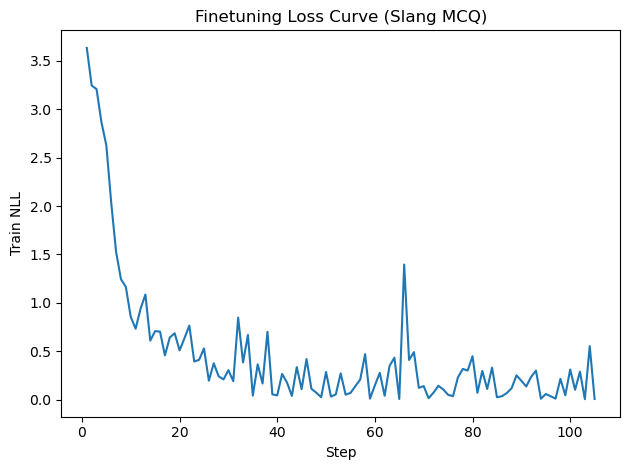

In [18]:
metrics_path = "logs/slang_run_01/metrics.jsonl"
df = pd.read_json(metrics_path, lines=True)

plt.figure()
plt.plot(df["step"], df["train_mean_nll"])
plt.xlabel("Step")
plt.ylabel("Train NLL")
plt.title("Finetuning Loss Curve (Slang MCQ)")
plt.tight_layout()
plt.show()

In [15]:
eval_finetuned(
    "data/eval_mcq.csv",
    "tinker://d8031ff1-8da5-5851-bf5d-7849cf38e28b:train:0/sampler_weights/slang-mcq-run-01"  # paste the path from training
)

=== FINETUNED RESULTS ===
Accuracy: 0.6464
Confusion matrix (rows=true, cols=pred; labels=A,B,C,D):
[97, 20, 23, 22]
[15, 102, 28, 14]
[13, 21, 129, 22]
[24, 20, 22, 118]

Classification report:
              precision    recall  f1-score   support

           A       0.65      0.60      0.62       162
           B       0.63      0.64      0.63       159
           C       0.64      0.70      0.67       185
           D       0.67      0.64      0.66       184

    accuracy                           0.65       690
   macro avg       0.65      0.64      0.64       690
weighted avg       0.65      0.65      0.65       690


Saved finetuned metrics to finetuned_metrics.json


In [39]:
service_client = tinker.ServiceClient()
training_client = service_client.create_lora_training_client(base_model=BASE_MODEL)
tokenizer = training_client.get_tokenizer()

examples = load_finetune_examples(FINETUNE_PATH)
datums = make_datums(examples, tokenizer)

metrics_path = LOG_DIR / "metrics.jsonl"

num_epochs = 5
batch_size = 16
learning_rate = 1e-4
global_step = 0

for epoch in range(1, num_epochs + 1):
    print(f"=== Epoch {epoch}/{num_epochs} ===")

    for batch in batch_iter(datums, batch_size=batch_size):
        global_step += 1

        fwdbwd_fut = training_client.forward_backward(batch, "cross_entropy")
        optim_fut = training_client.optim_step(
            types.AdamParams(learning_rate=learning_rate, beta1=0.89, beta2=0.99, eps=1e-8)
        )

        fwdbwd_res = fwdbwd_fut.result()
        optim_fut.result()

        # Use built-in loss metric instead of manually handling TensorData
        loss_sum = fwdbwd_res.metrics["loss:sum"]

        # Compute total number of *weighted* tokens for a mean NLL
        total_tokens = 0
        for d in batch:
            w = d.loss_fn_inputs["weights"]  # list or TensorData
            if hasattr(w, "data"):          # handle TensorData just in case
                w_np = np.array(w.data)
            else:
                w_np = np.array(w)
            total_tokens += (w_np > 0).sum()

        mean_nll = float(loss_sum / (total_tokens + 1e-8))

        record = {
            "step": global_step,
            "epoch": epoch,
            "train_loss_sum": float(loss_sum),
            "train_mean_nll": mean_nll,
        }
        with metrics_path.open("a", encoding="utf-8") as f:
            f.write(json.dumps(record) + "\n")

        if global_step % 5 == 0:
            print(
                f"step {global_step} | "
                f"train_loss_sum={loss_sum:.4f} | "
                f"train_mean_nll={mean_nll:.4f}"
            )
# Save weights for sampling (for eval_mcq_tinker.py)
resp = await training_client.save_weights_for_sampler(name="slang-mcq-run-03")
print("Saved sampler weights at:", resp.path)

=== Epoch 1/5 ===
step 5 | train_loss_sum=5.1815 | train_mean_nll=0.3238
step 10 | train_loss_sum=6.1109 | train_mean_nll=0.3819
step 15 | train_loss_sum=7.0097 | train_mean_nll=0.4381
step 20 | train_loss_sum=2.8234 | train_mean_nll=0.1765
step 25 | train_loss_sum=2.0581 | train_mean_nll=0.1286
step 30 | train_loss_sum=5.7541 | train_mean_nll=0.3596
step 35 | train_loss_sum=0.0288 | train_mean_nll=0.0096
=== Epoch 2/5 ===
step 40 | train_loss_sum=1.1856 | train_mean_nll=0.0741
step 45 | train_loss_sum=0.0074 | train_mean_nll=0.0005
step 50 | train_loss_sum=0.9180 | train_mean_nll=0.0574
step 55 | train_loss_sum=0.0020 | train_mean_nll=0.0001
step 60 | train_loss_sum=4.9656 | train_mean_nll=0.3104
step 65 | train_loss_sum=2.9032 | train_mean_nll=0.1815
step 70 | train_loss_sum=0.0128 | train_mean_nll=0.0043
=== Epoch 3/5 ===
step 75 | train_loss_sum=0.3292 | train_mean_nll=0.0206
step 80 | train_loss_sum=0.0090 | train_mean_nll=0.0006
step 85 | train_loss_sum=0.0347 | train_mean_nll=0.

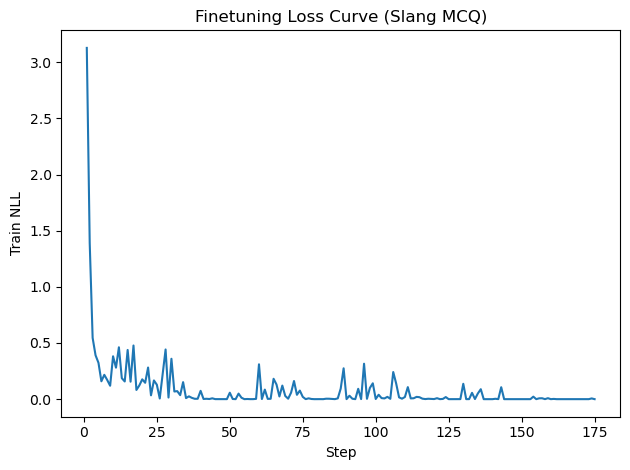

In [42]:
metrics_path = "logs/slang_run_03/metrics.jsonl"
df = pd.read_json(metrics_path, lines=True)

plt.figure()
plt.plot(df["step"], df["train_mean_nll"])
plt.xlabel("Step")
plt.ylabel("Train NLL")
plt.title("Finetuning Loss Curve (Slang MCQ)")
plt.tight_layout()
plt.show()

In [43]:
eval_finetuned(
    "data/eval_mcq.csv",
    "tinker://81cc8f01-19f4-5e69-8791-cedbfec148bb:train:0/sampler_weights/slang-mcq-run-03"  # paste the path from training
)

=== FINETUNED RESULTS ===
Accuracy: 0.7087
Confusion matrix (rows=true, cols=pred; labels=A,B,C,D):
[118, 19, 14, 11]
[11, 125, 16, 7]
[8, 28, 138, 11]
[16, 36, 24, 108]

Classification report:
              precision    recall  f1-score   support

           A       0.77      0.73      0.75       162
           B       0.60      0.79      0.68       159
           C       0.72      0.75      0.73       185
           D       0.79      0.59      0.67       184

    accuracy                           0.71       690
   macro avg       0.72      0.71      0.71       690
weighted avg       0.72      0.71      0.71       690


Saved finetuned metrics to finetuned_metrics.json


In [26]:
examples = load_finetune_examples(FINETUNE_PATH)
n_total = len(examples)
n_keep = int(n_total * FRACTION)

rng = np.random.default_rng(SEED)
perm = rng.permutation(n_total)
keep_idx = perm[:n_keep]

examples = [examples[i] for i in keep_idx]

print(f"Using {n_keep}/{n_total} finetune examples (fraction={FRACTION})")
datums = make_datums(examples, tokenizer)

Using 136/547 finetune examples (fraction=0.25)


In [27]:
len(datums)

136

In [28]:
service_client = tinker.ServiceClient()
training_client = service_client.create_lora_training_client(base_model=BASE_MODEL)
tokenizer = training_client.get_tokenizer()

# examples = load_finetune_examples(FINETUNE_PATH)
# datums = make_datums(examples, tokenizer)

metrics_path = LOG_DIR / "metrics.jsonl"

num_epochs = 5
batch_size = 16
learning_rate = 1e-4
global_step = 0

for epoch in range(1, num_epochs + 1):
    print(f"=== Epoch {epoch}/{num_epochs} ===")

    for batch in batch_iter(datums, batch_size=batch_size):
        global_step += 1

        fwdbwd_fut = training_client.forward_backward(batch, "cross_entropy")
        optim_fut = training_client.optim_step(
            types.AdamParams(learning_rate=learning_rate, beta1=0.89, beta2=0.99, eps=1e-8)
        )

        fwdbwd_res = fwdbwd_fut.result()
        optim_fut.result()

        # Use built-in loss metric instead of manually handling TensorData
        loss_sum = fwdbwd_res.metrics["loss:sum"]

        # Compute total number of *weighted* tokens for a mean NLL
        total_tokens = 0
        for d in batch:
            w = d.loss_fn_inputs["weights"]  # list or TensorData
            if hasattr(w, "data"):          # handle TensorData just in case
                w_np = np.array(w.data)
            else:
                w_np = np.array(w)
            total_tokens += (w_np > 0).sum()

        mean_nll = float(loss_sum / (total_tokens + 1e-8))

        record = {
            "step": global_step,
            "epoch": epoch,
            "train_loss_sum": float(loss_sum),
            "train_mean_nll": mean_nll,
        }
        with metrics_path.open("a", encoding="utf-8") as f:
            f.write(json.dumps(record) + "\n")

        if global_step % 5 == 0:
            print(
                f"step {global_step} | "
                f"train_loss_sum={loss_sum:.4f} | "
                f"train_mean_nll={mean_nll:.4f}"
            )
# Save weights for sampling (for eval_mcq_tinker.py)
resp = await training_client.save_weights_for_sampler(name="slang-mcq-run-02-25p")
print("Saved sampler weights at:", resp.path)

=== Epoch 1/5 ===
step 5 | train_loss_sum=8.0547 | train_mean_nll=0.5034
=== Epoch 2/5 ===
step 10 | train_loss_sum=3.1267 | train_mean_nll=0.1954
step 15 | train_loss_sum=1.2574 | train_mean_nll=0.0786
=== Epoch 3/5 ===
step 20 | train_loss_sum=0.0181 | train_mean_nll=0.0011
step 25 | train_loss_sum=0.2381 | train_mean_nll=0.0149
=== Epoch 4/5 ===
step 30 | train_loss_sum=0.0009 | train_mean_nll=0.0001
step 35 | train_loss_sum=0.0007 | train_mean_nll=0.0000
=== Epoch 5/5 ===
step 40 | train_loss_sum=0.0009 | train_mean_nll=0.0001
step 45 | train_loss_sum=0.0001 | train_mean_nll=0.0000
Saved sampler weights at: tinker://1dc19014-9375-51bd-87af-3426bea9dc50:train:0/sampler_weights/slang-mcq-run-02-25p


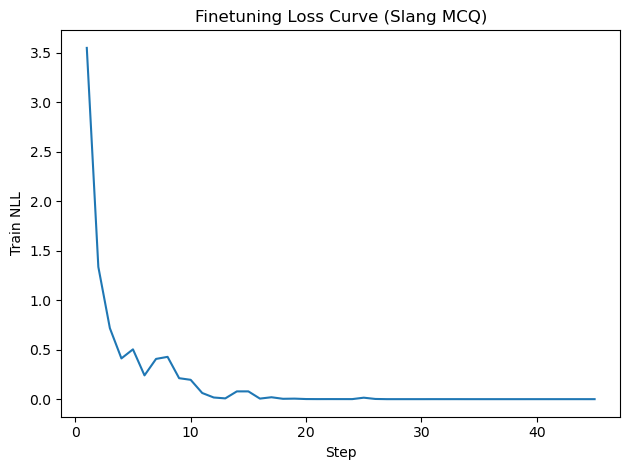

In [30]:
metrics_path = "logs/slang_run_02_25p/metrics.jsonl"
df = pd.read_json(metrics_path, lines=True)

plt.figure()
plt.plot(df["step"], df["train_mean_nll"])
plt.xlabel("Step")
plt.ylabel("Train NLL")
plt.title("Finetuning Loss Curve (Slang MCQ)")
plt.tight_layout()
plt.show()

In [31]:
eval_finetuned(
    "data/eval_mcq.csv",
    "tinker://1dc19014-9375-51bd-87af-3426bea9dc50:train:0/sampler_weights/slang-mcq-run-02-25p"  # paste the path from training
)

=== FINETUNED RESULTS ===
Accuracy: 0.6667
Confusion matrix (rows=true, cols=pred; labels=A,B,C,D):
[130, 12, 10, 10]
[39, 104, 11, 5]
[36, 20, 122, 7]
[43, 18, 19, 104]

Classification report:
              precision    recall  f1-score   support

           A       0.52      0.80      0.63       162
           B       0.68      0.65      0.66       159
           C       0.75      0.66      0.70       185
           D       0.83      0.57      0.67       184

    accuracy                           0.67       690
   macro avg       0.69      0.67      0.67       690
weighted avg       0.70      0.67      0.67       690


Saved finetuned metrics to finetuned_metrics.json


In [34]:
examples = load_finetune_examples(FINETUNE_PATH)
n_total = len(examples)
n_keep = int(n_total * FRACTION)

rng = np.random.default_rng(SEED)
perm = rng.permutation(n_total)
keep_idx = perm[:n_keep]

examples = [examples[i] for i in keep_idx]

print(f"Using {n_keep}/{n_total} finetune examples (fraction={FRACTION})")
datums = make_datums(examples, tokenizer)

Using 273/547 finetune examples (fraction=0.5)


In [35]:
service_client = tinker.ServiceClient()
training_client = service_client.create_lora_training_client(base_model=BASE_MODEL)
tokenizer = training_client.get_tokenizer()

# examples = load_finetune_examples(FINETUNE_PATH)
# datums = make_datums(examples, tokenizer)

metrics_path = LOG_DIR / "metrics.jsonl"

num_epochs = 5
batch_size = 16
learning_rate = 1e-4
global_step = 0

for epoch in range(1, num_epochs + 1):
    print(f"=== Epoch {epoch}/{num_epochs} ===")

    for batch in batch_iter(datums, batch_size=batch_size):
        global_step += 1

        fwdbwd_fut = training_client.forward_backward(batch, "cross_entropy")
        optim_fut = training_client.optim_step(
            types.AdamParams(learning_rate=learning_rate, beta1=0.89, beta2=0.99, eps=1e-8)
        )

        fwdbwd_res = fwdbwd_fut.result()
        optim_fut.result()

        # Use built-in loss metric instead of manually handling TensorData
        loss_sum = fwdbwd_res.metrics["loss:sum"]

        # Compute total number of *weighted* tokens for a mean NLL
        total_tokens = 0
        for d in batch:
            w = d.loss_fn_inputs["weights"]  # list or TensorData
            if hasattr(w, "data"):          # handle TensorData just in case
                w_np = np.array(w.data)
            else:
                w_np = np.array(w)
            total_tokens += (w_np > 0).sum()

        mean_nll = float(loss_sum / (total_tokens + 1e-8))

        record = {
            "step": global_step,
            "epoch": epoch,
            "train_loss_sum": float(loss_sum),
            "train_mean_nll": mean_nll,
        }
        with metrics_path.open("a", encoding="utf-8") as f:
            f.write(json.dumps(record) + "\n")

        if global_step % 5 == 0:
            print(
                f"step {global_step} | "
                f"train_loss_sum={loss_sum:.4f} | "
                f"train_mean_nll={mean_nll:.4f}"
            )
# Save weights for sampling (for eval_mcq_tinker.py)
resp = await training_client.save_weights_for_sampler(name="slang-mcq-run-02-50p")
print("Saved sampler weights at:", resp.path)

=== Epoch 1/5 ===
step 5 | train_loss_sum=3.8561 | train_mean_nll=0.2410
step 10 | train_loss_sum=5.4189 | train_mean_nll=0.3387
step 15 | train_loss_sum=1.2907 | train_mean_nll=0.0807
=== Epoch 2/5 ===
step 20 | train_loss_sum=0.0474 | train_mean_nll=0.0030
step 25 | train_loss_sum=0.4789 | train_mean_nll=0.0299
step 30 | train_loss_sum=0.0326 | train_mean_nll=0.0020
step 35 | train_loss_sum=0.0314 | train_mean_nll=0.0020
=== Epoch 3/5 ===
step 40 | train_loss_sum=0.0092 | train_mean_nll=0.0006
step 45 | train_loss_sum=0.0031 | train_mean_nll=0.0002
step 50 | train_loss_sum=0.0015 | train_mean_nll=0.0001
=== Epoch 4/5 ===
step 55 | train_loss_sum=0.0023 | train_mean_nll=0.0001
step 60 | train_loss_sum=0.0010 | train_mean_nll=0.0001
step 65 | train_loss_sum=0.0006 | train_mean_nll=0.0000
step 70 | train_loss_sum=0.0009 | train_mean_nll=0.0001
=== Epoch 5/5 ===
step 75 | train_loss_sum=0.0006 | train_mean_nll=0.0000
step 80 | train_loss_sum=0.0009 | train_mean_nll=0.0001
step 85 | train

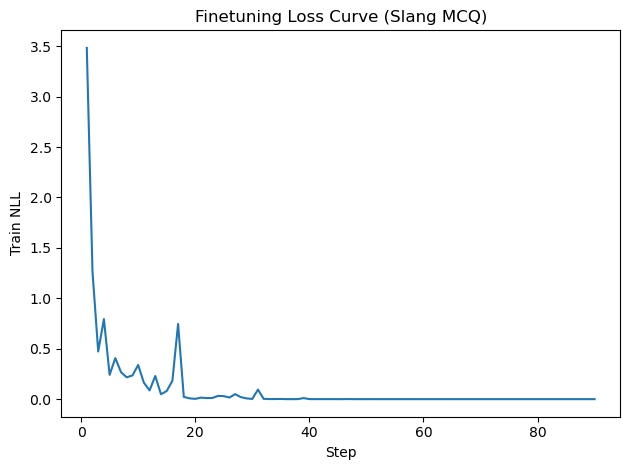

In [36]:
metrics_path = "logs/slang_run_02_50p/metrics.jsonl"
df = pd.read_json(metrics_path, lines=True)

plt.figure()
plt.plot(df["step"], df["train_mean_nll"])
plt.xlabel("Step")
plt.ylabel("Train NLL")
plt.title("Finetuning Loss Curve (Slang MCQ)")
plt.tight_layout()
plt.show()

In [37]:
eval_finetuned(
    "data/eval_mcq.csv",
    "tinker://f94cf944-69b7-5543-8773-67ac66a48c50:train:0/sampler_weights/slang-mcq-run-02-50p"  # paste the path from training
)

=== FINETUNED RESULTS ===
Accuracy: 0.7203
Confusion matrix (rows=true, cols=pred; labels=A,B,C,D):
[109, 18, 16, 19]
[11, 118, 15, 15]
[14, 18, 133, 20]
[15, 17, 15, 137]

Classification report:
              precision    recall  f1-score   support

           A       0.73      0.67      0.70       162
           B       0.69      0.74      0.72       159
           C       0.74      0.72      0.73       185
           D       0.72      0.74      0.73       184

    accuracy                           0.72       690
   macro avg       0.72      0.72      0.72       690
weighted avg       0.72      0.72      0.72       690


Saved finetuned metrics to finetuned_metrics.json
